## Visualizing  Spacy + Georesolver  - Total

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_Gazetteer/results_paper/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['Place']))
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['Place'], rotation=80, fontsize=7)

    if plot_type == "resolved":
        plt.bar(index, df_group_places['count'], color='green')
        plt.title('15 Places most mentioned using SpaCy and the Georesolver across all Scottitsh Gazetteer')
    else:
        plt.bar(index, df_group_places['count'], color='yellowgreen')
        plt.title('15 Places most mentioned but not resolved using SpaCy and the Georesolver across all Scottitsh Gazetteer')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [7]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [8]:
df_total= geresolution_dataframe(results)

year 1825
year 1828
year 1848
year 1883
year 1846
year 1868
year 1803
year 1806
year 1901
year 1838
year 1842
year 1882


In [9]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,,,B000071022,Page2,1825
1,55.95,-3.3725,EDINBURGH,Page3,1825
2,34.83349,-79.49977,SCOTLAND,Page3,1825
3,56.39153,-3.43951,Scotland,Page8,1825
4,,,E. to W.,Page8,1825


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    320629
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [11]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [12]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     36650
Longitude    36650
Place        36650
Page         36650
Year         36650
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [13]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [14]:
df_resolved = df_total[df_total['Latitude'] != '']

In [15]:
df_resolved.count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [16]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [17]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying just the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
1,55.95,-3.3725,Edinburgh,Page3,1825
2,34.83349,-79.49977,Scotland,Page3,1825
3,56.39153,-3.43951,Scotland,Page8,1825
5,46.216836478,-59.965143519,New aberdeen,Page8,1825
6,49.012779,2.55,Paris,Page8,1825
7,57.4666667,-4.2333333,Inverness,Page8,1825
8,57.1666667,-2.6666667,Aberdeenshire,Page8,1825
10,55.95,-3.3725,Edinburgh,Page8,1825
11,56.9667,-2.22563,Stonehaven,Page8,1825
16,56.39153,-3.43951,Scotland,Page8,1825


In [18]:
df_max_geolocations = df_capitalized[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_max_geolocations.count())
#displaying just the first 15 rows
df_max_geolocations.head(15)


Latitude     15212
Longitude    15212
count        15212
dtype: int64


,Latitude,Longitude,count
11882,55.8666667,-4.25,5518
12128,55.95,-3.3725,5515
12258,56,-4,4738
12932,56.5,-4,4342
12782,56.39153,-3.43951,3037
13577,57.1666667,-2.6666667,2721
13632,57.20194,-2.19778,2620
11911,55.87194,-4.43306,2567
12601,56.25,-3.1666667,2416
12444,56.1166667,-3.95,2254


In [19]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=[]
place_label, place_freq = label_freq_places(df_capitalized, df_max_geolocations, filter_list)

0 5518 Glasgow
1 5515 Edinburgh
2 4738 Scotland
3 4342 Perthshire
4 3037 Scotland
5 2721 Aberdeenshire
6 2620 Aberdeen
7 2567 Glasgow
8 2416 Fife
9 2254 Stirling
10 2201 Lanarkshire
11 2170 Edinburgh
12 2091 Perth
13 2045 Forfarshire
14 2017 Inverness
15 1995 Ayr
16 1893 Edinburgh
17 1810 Glasgow
18 1688 Dundee
19 1601 Tweed


In [20]:
#Visualizing the 15 places in a Bar plot
df_places = {'Place':place_label,'Place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_group_places

,Place,count
7,Glasgow,9895
4,Edinburgh,9578
12,Scotland,7775
11,Perthshire,4342
1,Aberdeenshire,2721
0,Aberdeen,2620
5,Fife,2416
13,Stirling,2254
9,Lanarkshire,2201
10,Perth,2091


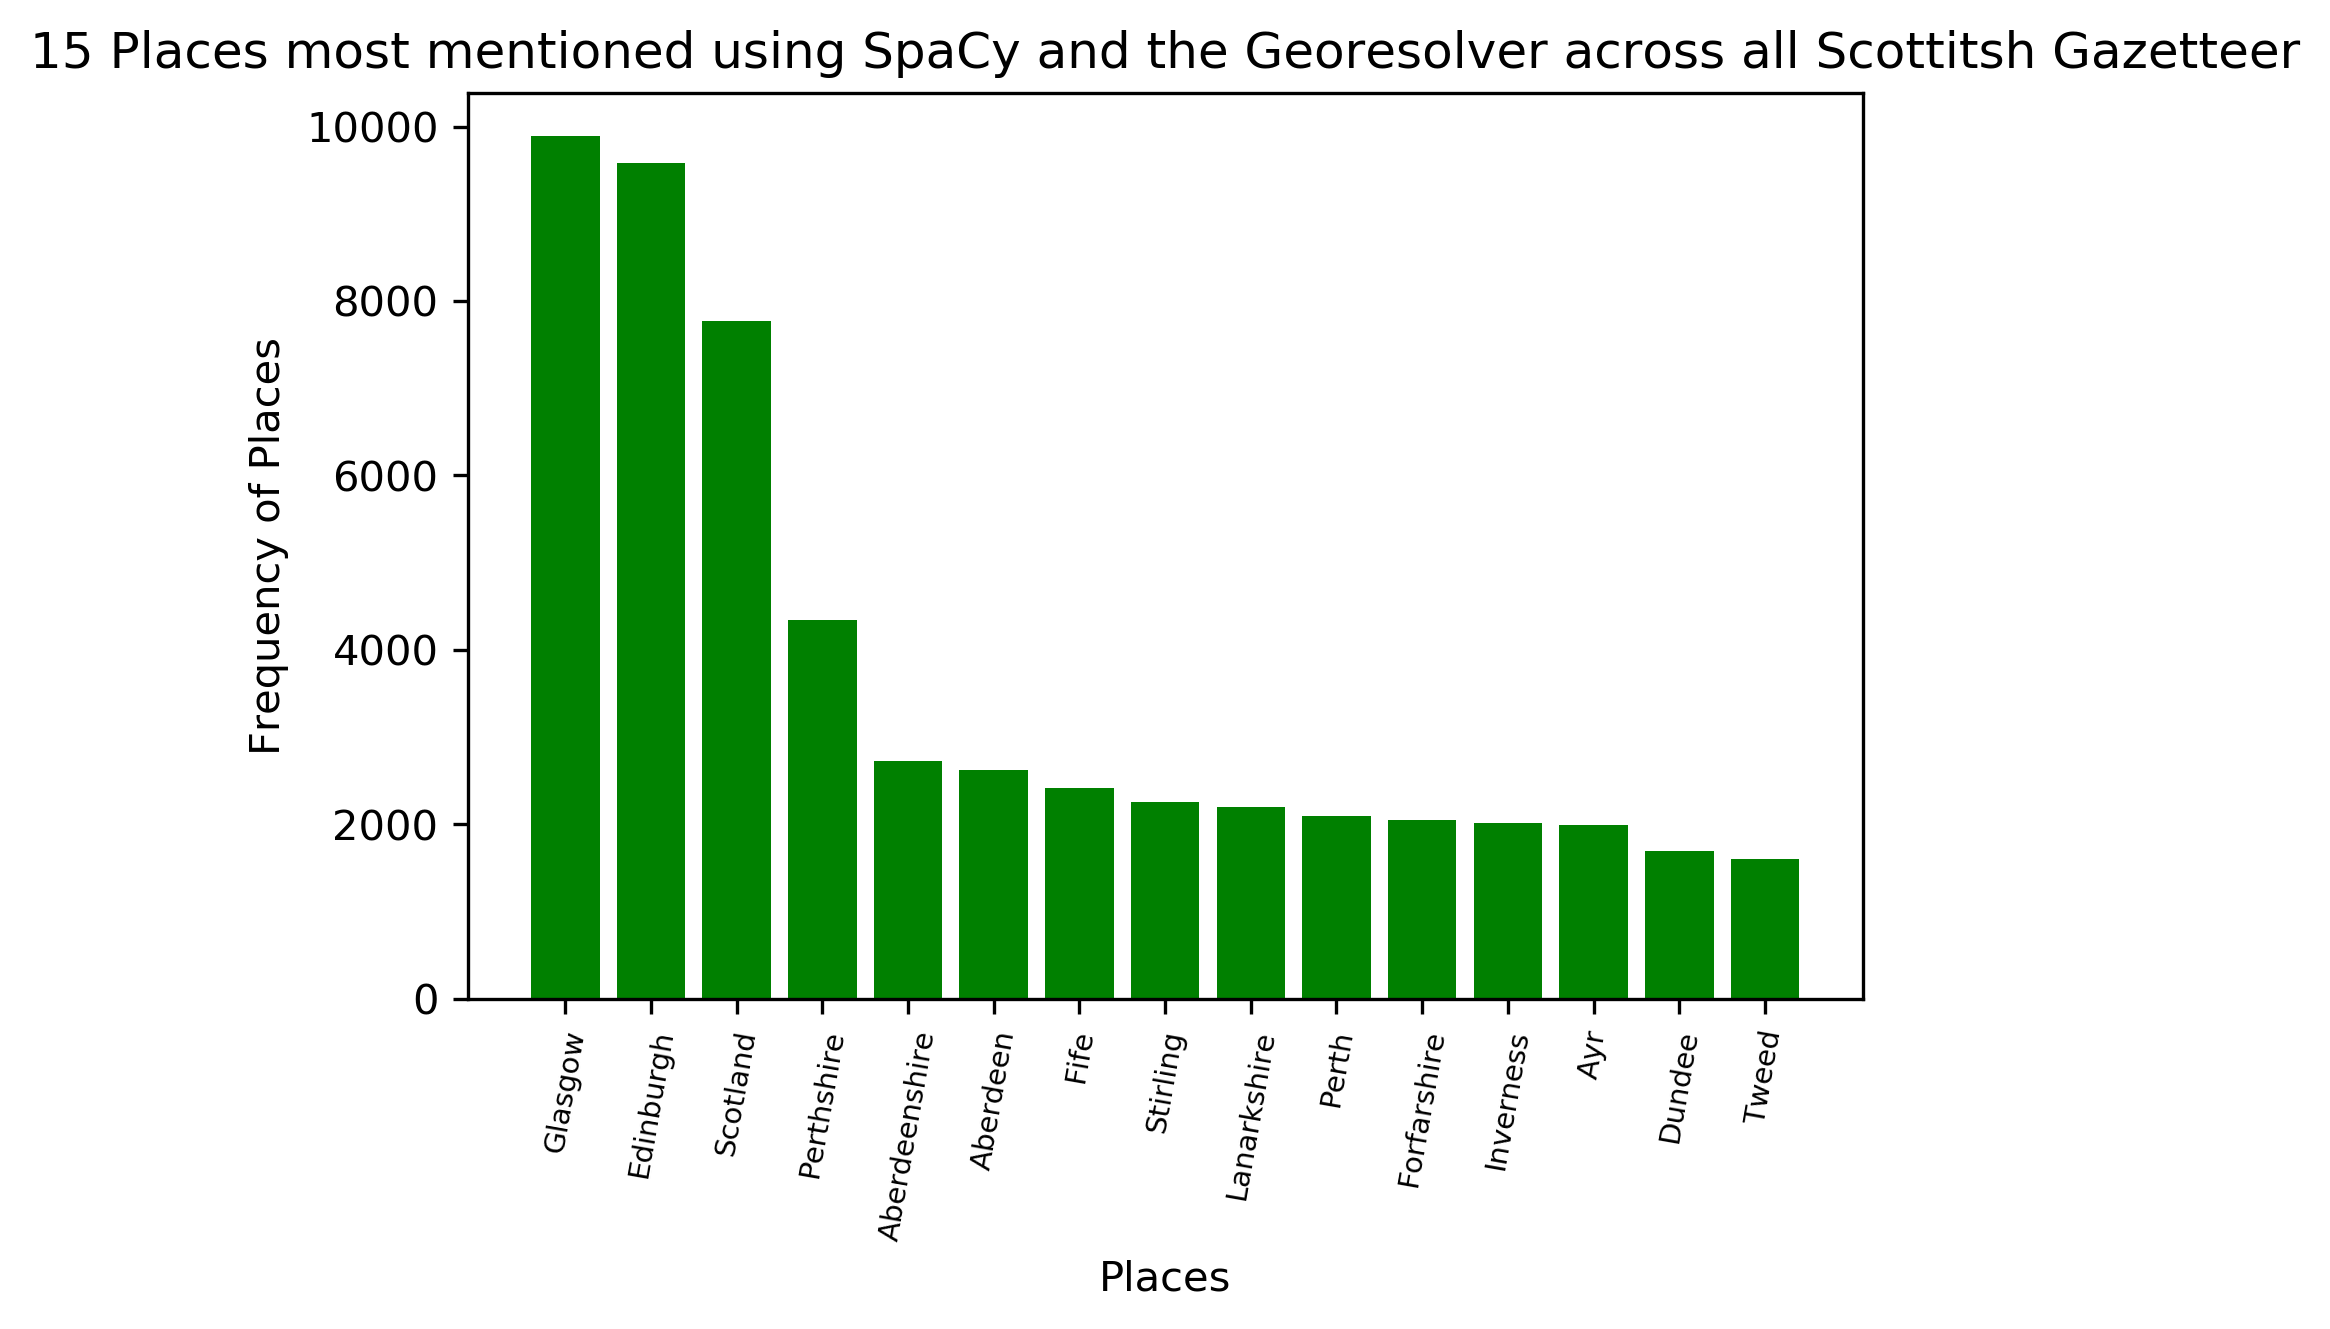

In [21]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places, plot_type='resolved')

## Exploring the locations not resolved - Not to be included in the paper

**Important - some years are missing here: 1803, 1846 (Vol 2), 1883(Vol 1, Vol 2), 1901**

Places names - forcing all to lower case, and later capitalize them

In [23]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [24]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)

In [25]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
#displapying the first 15 rows
df_not_resolved_max.head(15)

Place    13550
count    13550
dtype: int64


,Place,count
12021,Sur.,1214
9217,Nw,694
7327,Loch,648
3527,Dumfries,450
11281,St. andrews,394
551,Argyleshire,389
3967,Edinburghshire,325
8795,Ne,254
5157,Haddingtonshire,245
12041,Sw,226


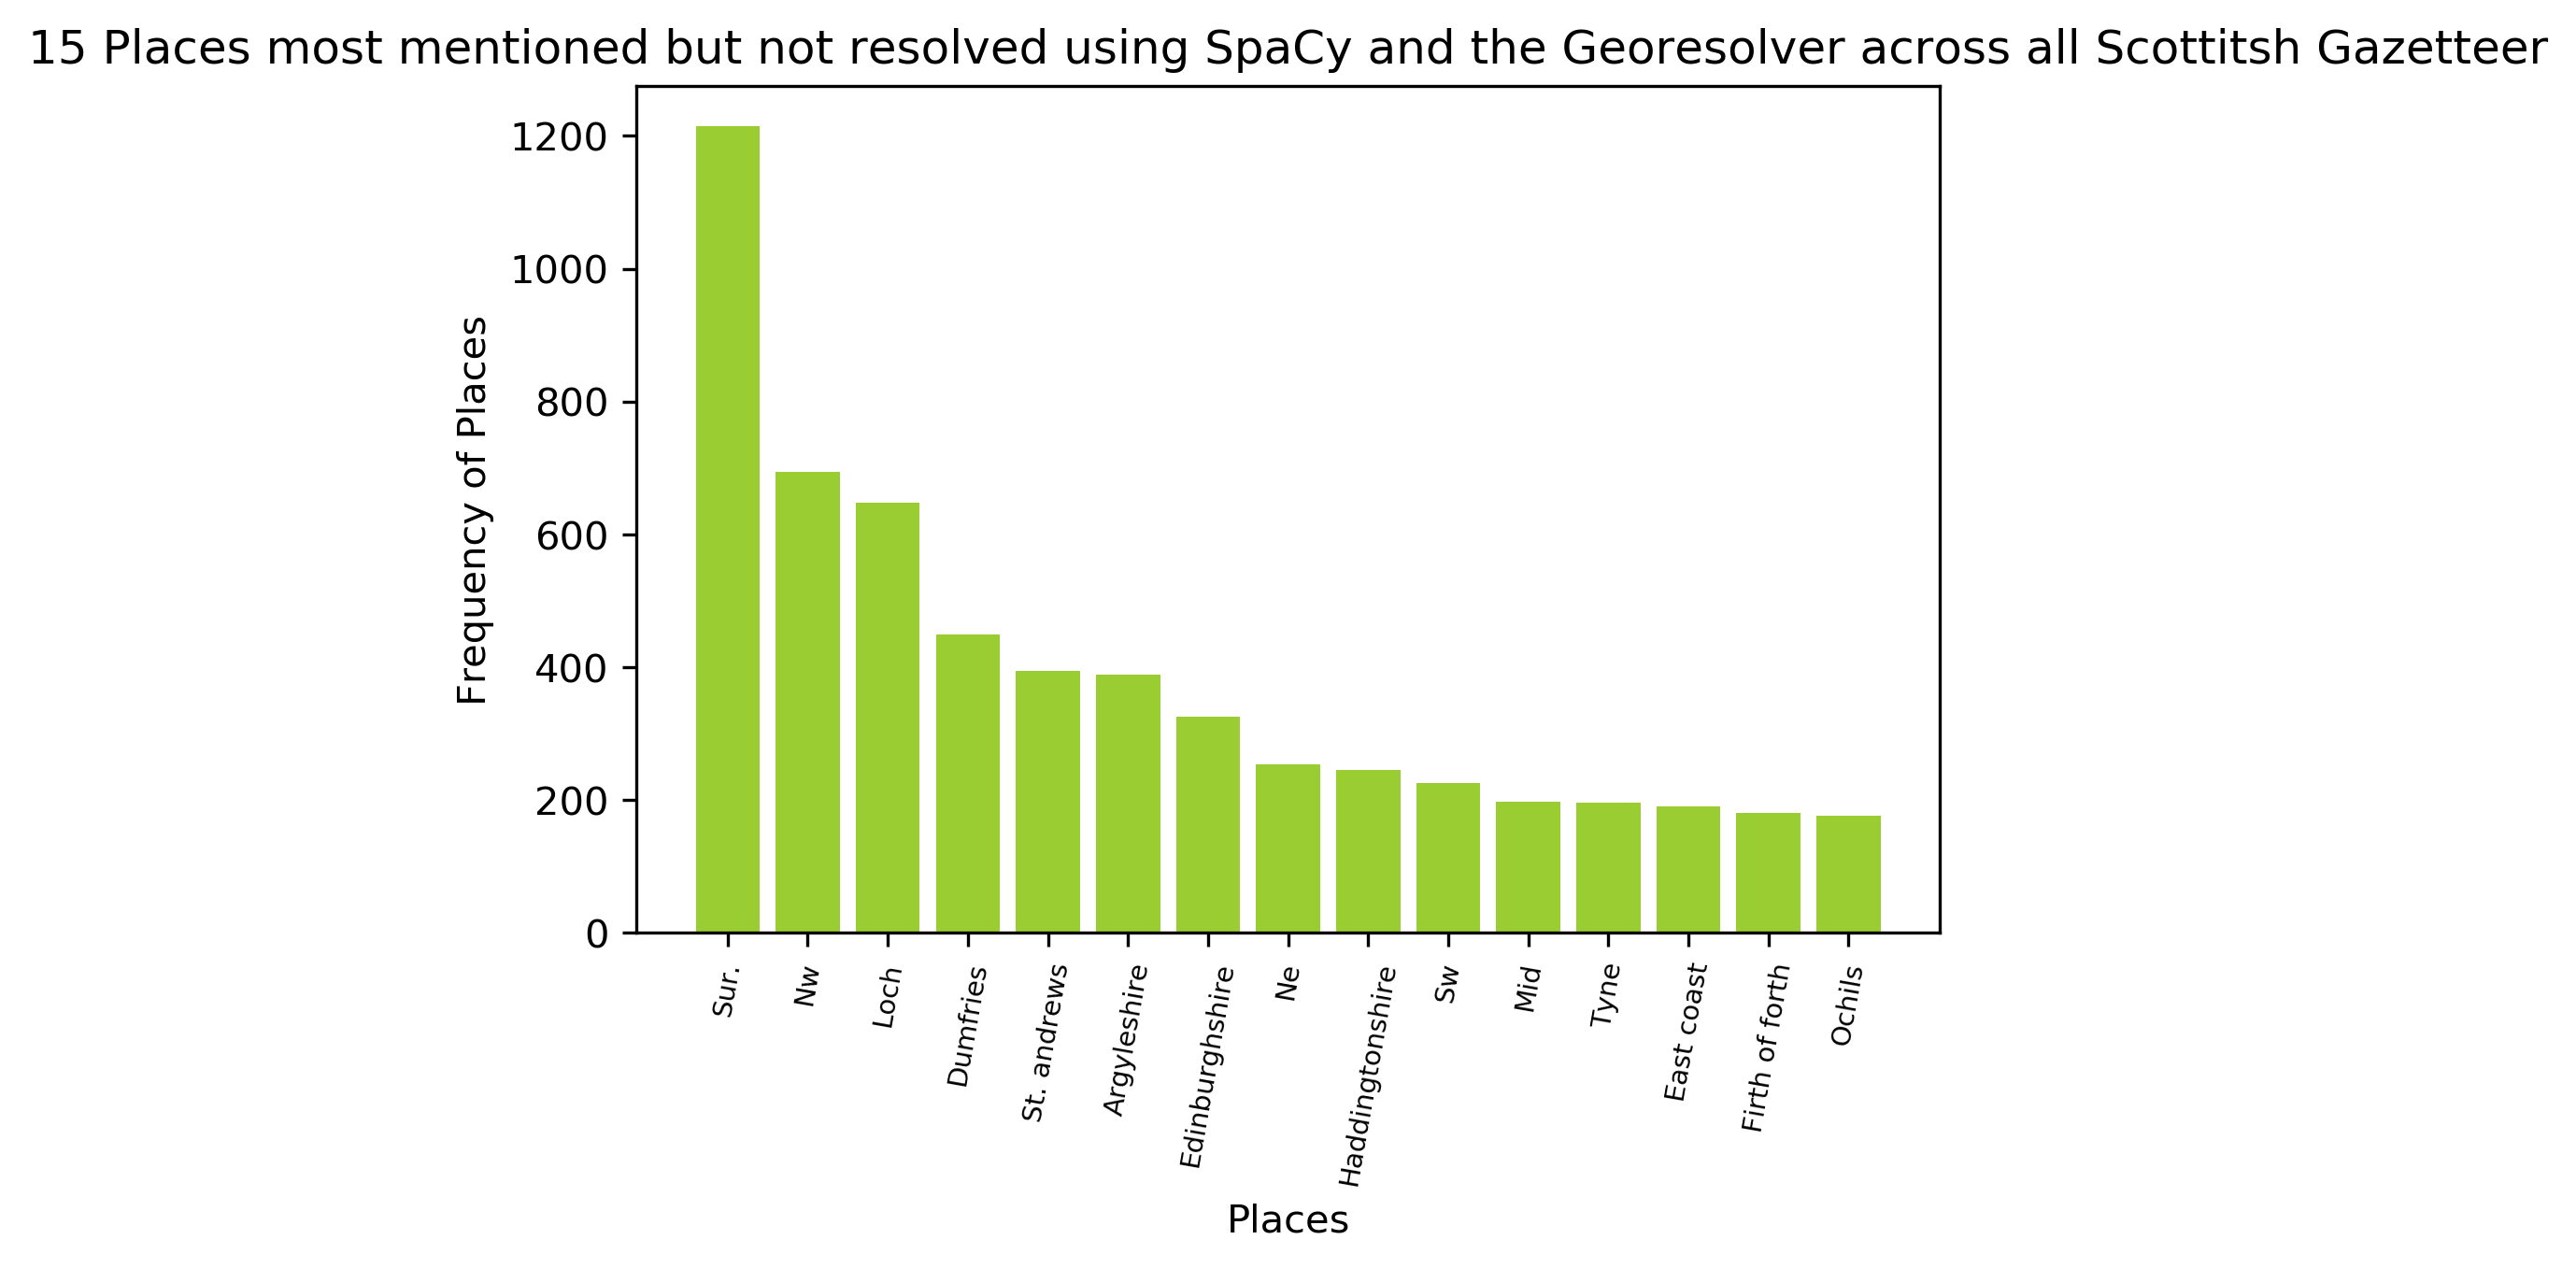

In [26]:
#Getting the 15 places (and their frequencies) most mentioned
df_not_resolved_15 = df_not_resolved_max.head(15)
plot_bar_places(df_not_resolved_15, plot_type="not_resolved")